In [1]:
import keras
import os
from keras.utils import to_categorical
import cv2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.layers import BatchNormalization

In [2]:
dataset_path = 'Progress'

# Initialize empty arrays to store images and labels
images = []
labels = []

# Initialize a dictionary to map class names to indices
class_index = {}

# Iterate through each directory (class) in the dataset directory
for index, class_name in enumerate(os.listdir(dataset_path)):
    class_path = os.path.join(dataset_path, class_name)
    
    # Skip if the current path is not a directory
    if not os.path.isdir(class_path):
        continue
    
    # Map class name to index
    class_index[class_name] = index
    
    # Iterate through each image in the current class directory
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        
        # Read the image using OpenCV
        image = cv2.imread(image_path)
        
        # Optionally, you can resize the image to a specific size if needed
        image = cv2.resize(image, (32, 32))
        
        # Append the image to the images array
        images.append(image)
        
        # Append the index corresponding to the class name to the labels array
        labels.append(index)

# Convert the images array to a numpy array
images = np.array(images)

# Convert the labels array to a numpy array
labels = np.array(labels)
labels_one_hot = to_categorical(labels)
# Print the shapes of images and labels arrays
print("Shape of images array:", images.shape)
print("Shape of labels array:", labels.shape)
print("Shape of labels array:", labels_one_hot.shape)

# Print the class index mapping
print("Class index mapping:", class_index)

Shape of images array: (57130, 32, 32, 3)
Shape of labels array: (57130,)
Shape of labels array: (57130, 15)
Class index mapping: {'Atelectasis': 0, 'Cardiomegaly': 1, 'Consolidation': 2, 'Edema': 3, 'Effusion': 4, 'Emphysema': 5, 'Fibrosis': 6, 'Hernia': 7, 'Infiltration': 8, 'Mass': 9, 'No Finding': 10, 'Nodule': 11, 'Pleural_Thickening': 12, 'Pneumonia': 13, 'Pneumothorax': 14}


In [3]:
labels_one_hot


array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [4]:
dataset_path = 'Progress'  # Adjust the path as needed

# Define a threshold for the minimum number of images per class
min_images_threshold = 500  # Adjust as needed

# Initialize a dictionary to map class names to indices and count the number of images per class
class_index = {}
class_image_count = {}
# Iterate through each directory (class) in the dataset directory
for index, class_name in enumerate(os.listdir(dataset_path)):
    class_path = os.path.join(dataset_path, class_name)
    
    # Skip if the current path is not a directory
    if not os.path.isdir(class_path):
        continue
    
    # Count the number of images in the current class
    image_count = len(os.listdir(class_path))
    class_image_count[class_name] = image_count
    class_index[class_name] = index
    
class_image_count

{'Atelectasis': 2210,
 'Cardiomegaly': 746,
 'Consolidation': 346,
 'Edema': 51,
 'Effusion': 2086,
 'Emphysema': 525,
 'Fibrosis': 648,
 'Hernia': 98,
 'Infiltration': 5270,
 'Mass': 1367,
 'No Finding': 39302,
 'Nodule': 1924,
 'Pleural_Thickening': 875,
 'Pneumonia': 176,
 'Pneumothorax': 1506}

In [5]:
labels

array([ 0,  0,  0, ..., 14, 14, 14])

In [6]:
len(class_index)

15

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
if len(labels) == 0:
    raise ValueError("No images found in the dataset directory.")

# Normalize images
images = images / 255.

# Apply data augmentation selectively for classes with fewer images
augmented_images = []
augmented_labels = []

for class_name, image_count in class_image_count.items():
    # Skip classes with sufficient data
    if image_count >= min_images_threshold:
        continue
    
    # Create ImageDataGenerator instance for the current class
    datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='constant',
        cval=125
    )
    
    # Generate augmented data for the current class
    class_path = os.path.join(dataset_path, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image = cv2.imread(image_path)
        image = cv2.resize(image, (32, 32))
        image = np.expand_dims(image, axis=0)
        x=0;
        for batch in datagen.flow(image, batch_size=32):
            augmented_images.append(batch[0])
            augmented_labels.append(class_index[class_name])
            x+=1
            if(x>30):
                x=0
                break
              # Ensure only one augmentation per original image

# Convert augmented images and labels arrays to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# One-hot encode labels for both original and augmented data
labels_one_hot = to_categorical(labels, num_classes=len(class_index))
augmented_labels_one_hot = to_categorical(augmented_labels, num_classes=len(class_index))

# Concatenate original and augmented data
final_images = np.concatenate((images, augmented_images), axis=0)
final_labels = np.concatenate((labels_one_hot, augmented_labels_one_hot), axis=0)

# Shuffle the data (optional)
shuffle_indices = np.random.permutation(len(final_images))
final_images = final_images[shuffle_indices]
final_labels = final_labels[shuffle_indices]

In [9]:
augmented_images

array([[[[125.       , 125.       , 125.       ],
         [125.       , 125.       , 125.       ],
         [164.4817   , 164.4817   , 164.4817   ],
         ...,
         [ 82.25556  ,  82.25556  ,  82.25556  ],
         [125.       , 125.       , 125.       ],
         [125.       , 125.       , 125.       ]],

        [[125.       , 125.       , 125.       ],
         [125.       , 125.       , 125.       ],
         [172.84296  , 172.84296  , 172.84296  ],
         ...,
         [139.80128  , 139.80128  , 139.80128  ],
         [125.       , 125.       , 125.       ],
         [125.       , 125.       , 125.       ]],

        [[125.       , 125.       , 125.       ],
         [125.       , 125.       , 125.       ],
         [181.55486  , 181.55486  , 181.55486  ],
         ...,
         [142.37007  , 142.37007  , 142.37007  ],
         [125.       , 125.       , 125.       ],
         [125.       , 125.       , 125.       ]],

        ...,

        [[125.       , 125.       , 12

In [10]:
augmented_labels_one_hot

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [11]:
len(labels_one_hot)

57130

In [12]:
SIZE = 224
# X_train, X_test, y_train, y_test = train_test_split(final_images, final_labels, random_state=42, test_size=0.3)

from sklearn.model_selection import train_test_split

# First, split the data into training/validation and test sets (80/20 split)
X_train_val, X_test, y_train_val, y_test = train_test_split(final_images, final_labels, test_size=0.2, random_state=42)

# Then, split the training/validation set into separate training and validation sets (80/20 split of the 80%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Normalize the images if not already done
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test.shape}")


Training set size: (46758, 32, 32, 3)
Validation set size: (15586, 32, 32, 3)
Test set size: (15587, 32, 32, 3)


In [13]:
from keras.applications import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

# Step 1: Define the DenseNet model architecture
base_model = DenseNet121(weights='imagenet' , include_top=False)  # Load pre-trained weights from ImageNet

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling layer
x = Dense(1024, activation='relu')(x)  # Fully connected layer
predictions = Dense(15, activation='sigmoid')(x)  # Output layer

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

from keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0001) 
metrics = ['accuracy', 'precision', 'recall', 'f1_score']

# Step 2: Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, None, None, 3)     │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, None, None, 3)     │               0 │ input_layer[0][0]          │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, None, None, 64)    │           9,408 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, None, None, 64)    │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, None, None, 64)    │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, None, None, 64)    │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, None, None, 64)    │               0 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, None, None, 64)    │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, None, None, 64)    │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, None, None, 128)   │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, None, None, 128)   │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, None, None, 128)   │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, None, None, 32)    │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, None, None, 96)    │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 8,102,479 (30.91 MB)

 Trainable params: 8,018,831 (30.59 MB)

 Non-trainable params: 83,648 (326.75 KB)

Epoch 1/10
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 297s 158ms/step - accuracy: 0.6117 - f1_score: 0.1243 - loss: 0.1564 - precision: 0.6048 - recall: 0.5757 - val_accuracy: 0.6331 - val_f1_score: 0.1539 - val_loss: 0.1369 - val_precision: 0.6623 - val_recall: 0.5791
Epoch 2/10
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 225s 154ms/step - accuracy: 0.6483 - f1_score: 0.1572 - loss: 0.1310 - precision: 0.6652 - recall: 0.6121 - val_accuracy: 0.6717 - val_f1_score: 0.1967 - val_loss: 0.1261 - val_precision: 0.6812 - val_recall: 0.6499
Epoch 3/10
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 224s 153ms/step - accuracy: 0.6665 - f1_score: 0.1946 - loss: 0.1268 - precision: 0.6788 - recall: 0.6399 - val_accuracy: 0.6675 - val_f1_score: 0.1974 - val_loss: 0.1292 - val_precision: 0.6817 - val_recall: 0.6433
Epoch 4/10
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 229s 157ms/step - accuracy: 0.6910 - f1_score: 0.2285 - loss: 0.1216 - precision: 0.6978 - recall: 0.6744 - val_accuracy: 0.6942 - val_f1_score: 0.2245 - val_loss: 0.1207 - val_precisi

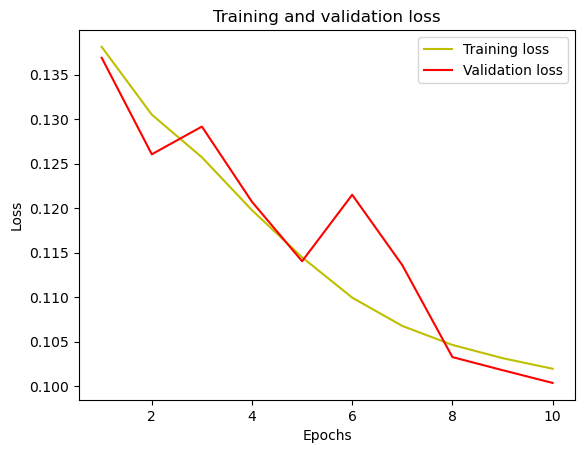

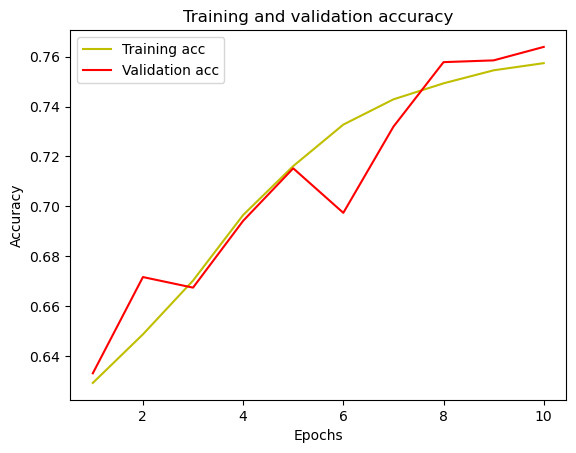

In [14]:
# model = Sequential()

# model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(SIZE, SIZE, 3)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))

# model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(5, activation='sigmoid'))


# #Do not use softmax for multilabel classification
# #Softmax is useful for mutually exclusive classes, either cat or dog but not both.
# #Also, softmax outputs all add to 1. So good for multi class problems where each
# #class is given a probability and all add to 1. Highest one wins. 

# #Sigmoid outputs probability. Can be used for non-mutually exclusive problems.
# #like multi label, in this example.
# #But, also good for binary mutually exclusive (cat or not cat). 

# model.summary()

#Binary cross entropy of each label. So no really a binary classification problem but
#Calculating binary cross entropy for each label. 
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

# history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
# #################################################
# # #Validate on an image
# from tensorflow.keras.preprocessing import image

# img = image.load_img("C:/Users/rasen/Image_processing/intern/Progress_short/Edema/00012364_005.png", target_size=(SIZE,SIZE,3))
# # img = image.load_img('cons.png', target_size=(SIZE,SIZE,3))

# img = image.img_to_array(img)
# img = img/255.
# plt.imshow(img)
# img = np.expand_dims(img, axis=0)

# classes = np.array(df.columns[2:]) #Get array of all classes
# proba = model.predict(img)  #Get probabilities for each class
# sorted_categories = np.argsort(proba[0])[:-11:-1]  #Get class names for top 10 categories

# #Print classes and corresponding probabilities
# for i in range(10):
#     print("{}".format(classes[sorted_categories[i]])+" ({:.3})".format(proba[0][sorted_categories[i]]))

# ###################################################

# _, acc = model.evaluate(X_test, y_test)
# print("Accuracy = ", (acc * 100.0), "%")

# # ################################################################

In [17]:
# Evaluate the model on the test set
# Evaluate the model on the test set
evaluation_metrics = model.evaluate(X_test, y_test, verbose=1)

# Unpack the returned values
test_loss = evaluation_metrics[0]
test_accuracy = evaluation_metrics[1]
test_precision = evaluation_metrics[2]
test_recall = evaluation_metrics[3]
test_auc = evaluation_metrics[4]

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")

488/488 ━━━━━━━━━━━━━━━━━━━━ 24s 49ms/step - accuracy: 0.7606 - f1_score: 0.3033 - loss: 0.1010 - precision: 0.7613 - recall: 0.7607
Test Loss: 0.10004708170890808
Test Accuracy: 0.7639058232307434
Test Precision: 0.7643054127693176
Test Recall: 0.7635208964347839
Test AUC: [0.         0.         0.9490591  0.88983047 0.         0.
 0.         0.96218824 0.         0.         0.818606   0.
 0.         0.93021154 0.        ]


488/488 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step
                    precision    recall  f1-score   support

      Cardiomegaly       0.00      0.00      0.00       432
         Emphysema       0.00      0.00      0.00       144
          Effusion       0.99      0.91      0.95      2274
            Hernia       0.86      0.92      0.89       342
      Infiltration       0.00      0.00      0.00       400
              Mass       0.00      0.00      0.00        98
        No Finding       0.00      0.00      0.00       124
            Nodule       0.97      0.96      0.96       626
       Atelectasis       0.00      0.00      0.00      1038
      Pneumothorax       0.00      0.00      0.00       296
Pleural_Thickening       0.69      1.00      0.82      7893
         Pneumonia       0.00      0.00      0.00       355
          Fibrosis       0.00      0.00      0.00       170
             Edema       0.91      0.95      0.93      1092
     Consolidation       0.00      0.00      0.00       

C:\Users\rasen\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rasen\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rasen\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


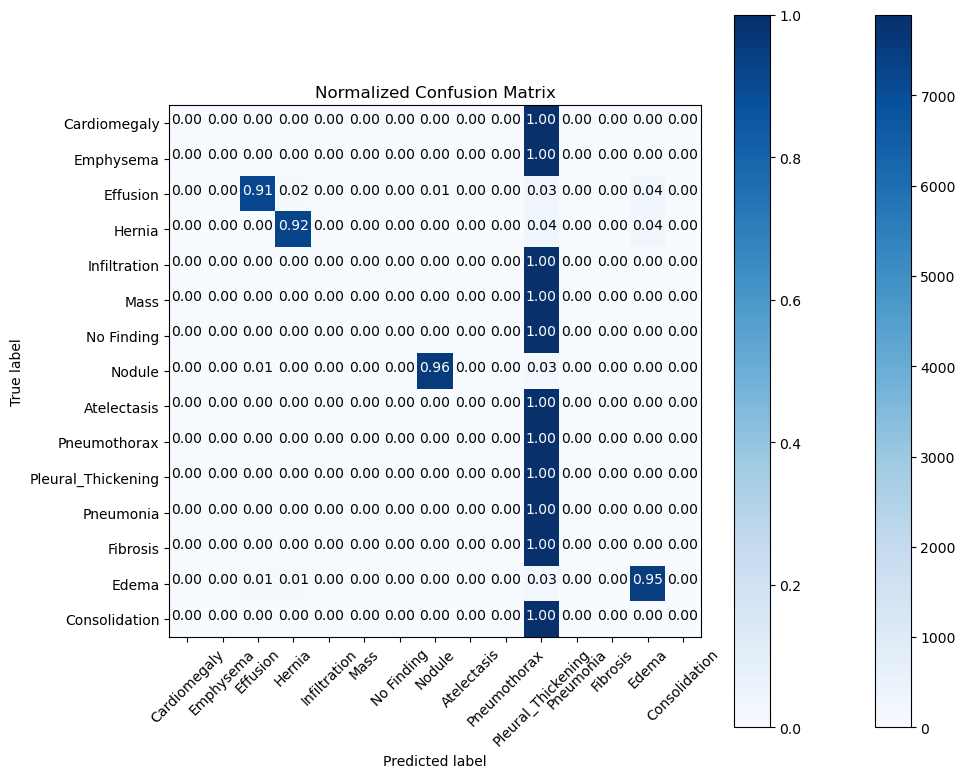

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test)

# Convert predictions from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Get the class labels
classes = [
    'Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 
    'Mass', 'No Finding', 'Nodule', 'Atelectasis', 'Pneumothorax', 
    'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation'
]

# Print the classification report
print(classification_report(y_test_classes, y_pred_classes, target_names=classes))

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Normalize the confusion matrix
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Plot the numbers in the confusion matrix
thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], '.2f'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:

# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# plt.plot(epochs, acc, 'y', label='Training acc')
# plt.plot(epochs, val_acc, 'r', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()



In [20]:
from tensorflow.keras.preprocessing import image

# Load the image
img_path = 'C:/Users/rasen/Image_processing/intern/Progress_short/Edema/00012364_005.png'
img = image.load_img(img_path, target_size=(224, 224))  # Load and resize the image

# Convert the image to a numpy array and normalize the pixel values
img_array = image.img_to_array(img)
img_array = img_array / 255.

# Expand the dimensions to match the model's input shape
img_array = np.expand_dims(img_array, axis=0)

# Use the model to predict the probabilities for each class
proba = model.predict(img_array)

# Get the class labels
classes = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'No Finding',
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']  # Replace with your actual class names

# Display the predicted probabilities for each class
for i, class_name in enumerate(classes):
    print(f"{class_name}: {proba[0][i]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Cardiomegaly: 1.604790469400541e-07
Emphysema: 7.967118875740198e-08
Effusion: 0.9168562293052673
Hernia: 5.310529741109349e-05
Infiltration: 4.297069366998585e-08
Mass: 6.446380762525905e-09
No Finding: 8.851770871842746e-09
Nodule: 0.0003132175770588219
Atelectasis: 9.42084952271216e-08
Pneumothorax: 1.6696220939138584e-07
Pleural_Thickening: 6.561659574799705e-06
Pneumonia: 5.208525877264947e-08
Fibrosis: 5.356770138575939e-09
Edema: 0.002471641404554248
Consolidation: 2.246157926322212e-08
